<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [9]:
!nvidia-smi

Tue Jan  3 19:02:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   47C    P0    56W / 300W |   4292MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [8]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch.optim import AdamW
from torchmetrics import MeanSquaredError as mse, MeanAbsoluteError as mae
from torch.optim.lr_scheduler import CosineAnnealingLR
from IPython.display import clear_output

import os
import pandas as pd
import skimage
from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as TT

%matplotlib inline

In [2]:
# !nvidia-smi

In [3]:
%env NVIDIA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=2

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

env: NVIDIA_VISIBLE_DEVICES=1
env: CUDA_VISIBLE_DEVICES=2
1
2


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [5]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [27]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

(13143, 76)


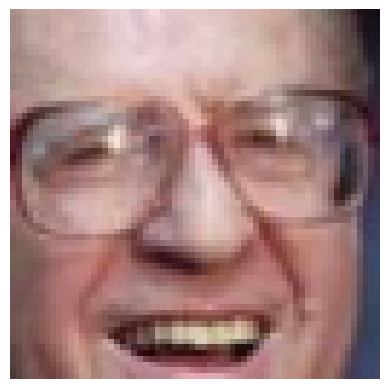

In [28]:
plt.imshow(data[11])
plt.axis('off')
plt.show()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train, val = train_test_split(data, test_size=0.33)

train.shape[0], val.shape[0]

(8805, 4338)

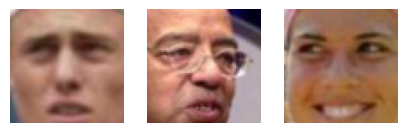

In [31]:
_, axes = plt.subplots(ncols=3, figsize=(5, 15))

for img_id, ax in zip(np.random.choice(data.shape[0], 3), axes.ravel()):
    
    ax.axis('off')
    ax.imshow(data[img_id])
    
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучим обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [6]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, flatten_dim):
        super().__init__()
        
        self.layers = nn.Sequential(  
            nn.Linear(flatten_dim, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, 128),
            nn.ReLU(),
            
            nn.Linear(128, hidden_dim)
        )        
        
    def forward(self, x):
        
        enc_input = x.flatten(start_dim=1)
        
        return self.layers(enc_input)
    
class Decoder(nn.Module):
    def __init__(self, hidden_dim, flatten_dim, orig_shape):
        super().__init__()
        
        self.orig_shape = orig_shape
        
        self.layers = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            
            nn.Linear(128, 512),
            nn.ReLU(),
            
            nn.Linear(512, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, flatten_dim),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        
        out = self.layers(x)
        
        return out.unflatten(1, self.orig_shape)

In [7]:
class LitAE(pl.LightningModule):
    def __init__(self, hidden_dim, orig_shape, n_epochs):
        super().__init__()
        
        self.n_epochs = n_epochs
        
        flatten_dim = np.prod(list(orig_shape), dtype=int)
        
        self.encoder = Encoder(
            hidden_dim,
            flatten_dim
        )

        self.decoder = Decoder(
            hidden_dim,
            flatten_dim,
            orig_shape=train_loader.dataset[0].shape
        )
            
        self.val_loss_history = []
        
        self.train_MAE = mae()
        self.val_MAE = mae()
        self.save_hyperparameters()
            
    def forward(self, x):
        
        latent_code = self.encoder(x)
        
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-3)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.n_epochs//3, eta_min=1e-8)
        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch
        
        out, _ = self.forward(x)
        
        self.train_MAE(out, x)
        self.log('train_MAE', self.train_MAE, on_step=False, on_epoch=True)
        
        loss = nn.functional.mse_loss(out, x)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch
        
        out, _  = self.forward(x)
        
        self.val_MAE(out, x)
        self.log('val_MAE', self.val_MAE, on_step=False, on_epoch=True)
        
        loss = nn.functional.mse_loss(out, x)
        
        return {'val_MAE': loss}
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_MAE'].detach().cpu() for x in outputs]).mean()
        
        self.val_loss_history.append(avg_val_loss.numpy())
        
        clear_output(wait=True)
        plt.plot(self.val_loss_history, label=f'Validation loss: {avg_val_loss.numpy():.3f}')
        plt.scatter(np.argmin(self.val_loss_history), y=min(self.val_loss_history), c='r', marker='*', label='min val loss')
        plt.scatter(len(self.val_loss_history)-1, y=avg_val_loss.numpy(), c='k', marker='o', label='current loss')
        
        plt.title(f'Epoch: {len(self.val_loss_history)-1}/{self.n_epochs}')
        
        plt.legend()
        plt.show()        

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [741]:
BATCH_SIZE = 128
N_EPOCHS = 100

In [742]:
train_loader = DataLoader(
    torch.FloatTensor(np.moveaxis(train, -1, 1)),
    batch_size=BATCH_SIZE, 
    pin_memory=True,
    num_workers=40,
    shuffle=True
)

val_loader = DataLoader(
    torch.FloatTensor(np.moveaxis(val, -1, 1)),
    batch_size=BATCH_SIZE, 
    pin_memory=True,
    num_workers=40
)

train_loader.dataset.shape[0], val_loader.dataset.shape[0]

(8805, 4338)

In [743]:
vanilla_AE_path='vanilla_AE_pathAE'
!rm -rf checkpoints/

In [95]:
import gc

torch.cuda.empty_cache()
gc.collect()

469617

In [745]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_MAE',
    filename=vanilla_AE_path,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
    log_every_n_steps=len(train_loader)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [746]:
model = LitAE(
    hidden_dim=300,
    orig_shape=train_loader.dataset[0].shape,
    n_epochs=N_EPOCHS
).to(DEVICE)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

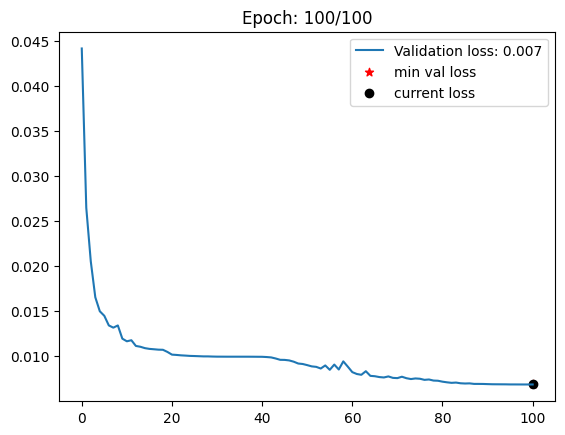

`Trainer.fit` stopped: `max_epochs=100` reached.


In [747]:
trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

In [678]:
!ls -l checkpoints

total 309328
-rw-rw-r-- 1 v_chernyy v_chernyy 316745810 дек 20 04:03 vanilla_AE_pathAE.ckpt


In [748]:
model = LitAE.load_from_checkpoint(f'checkpoints/{vanilla_AE_path}.ckpt')

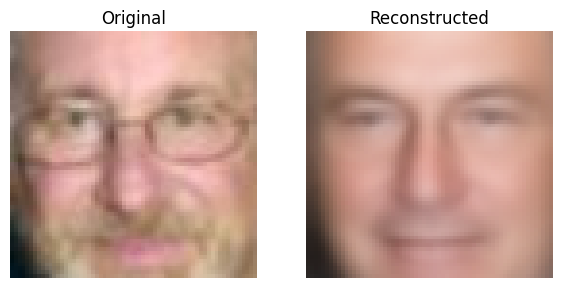

In [840]:
# disable randomness, dropout, etc...
model.eval()

sample = val_loader.dataset[-10].unsqueeze(0)

# predict with the model
y_hat, _ = model(sample)

_, axes= plt.subplots(figsize=(7, 10), ncols=2)

sample = np.moveaxis(sample.squeeze().detach().cpu().numpy(), 0, -1)

y_hat = np.moveaxis(y_hat.squeeze().detach().cpu().numpy(), 0, -1)

axes[0].imshow(sample)
axes[0].axis('off')
axes[0].set_title('Original')

axes[1].imshow(y_hat)
axes[1].axis('off')
axes[1].set_title('Reconstructed')

plt.show()

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [754]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 300))
output = model.decoder(z)
output.shape

torch.Size([25, 3, 64, 64])

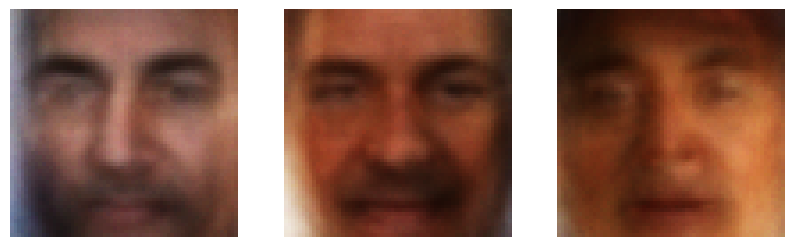

In [755]:
_, axes = plt.subplots(ncols=3, figsize=(10, 5))

for img_id, ax in zip(np.random.choice(output.shape[0], 3), axes.ravel()):
    
    ax.axis('off')
    ax.imshow(np.moveaxis(output[img_id].squeeze().detach().cpu().numpy(), 0, -1))
    
plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [35]:
def show_images(data):

    _, axes = plt.subplots(ncols=data.shape[0], figsize=(15, 10))

    for img, ax in zip(data, axes.ravel()):

        ax.axis('off')
        ax.imshow(img)

    plt.show()

In [831]:
sad_list = np.argsort(attrs.Smiling.values)[:15]
sad_list.shape

(15,)

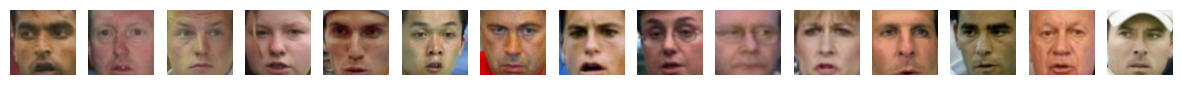

In [832]:
show_images(data[sad_list])

In [833]:
smiling_list = np.argsort(attrs.Smiling.values)[-15:]
smiling_list.shape

(15,)

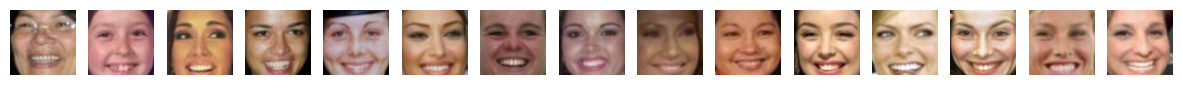

In [834]:
show_images(data[smiling_list])

In [835]:
sad_batch = torch.stack([torch.FloatTensor(np.moveaxis(data[idx], -1, 0)) for idx in sad_list], 0)

smiling_batch = torch.stack([torch.FloatTensor(np.moveaxis(data[idx], -1, 0)) for idx in smiling_list], 0)

sad_batch.shape, smiling_batch.shape

(torch.Size([15, 3, 64, 64]), torch.Size([15, 3, 64, 64]))

In [836]:
with torch.no_grad():
    mean_sad_latent = torch.mean(model.encoder(sad_batch), 0)
    mean_smiling_latent = torch.mean(model.encoder(smiling_batch), 0)
    
mean_sad_latent.shape, mean_smiling_latent.shape

(torch.Size([300]), torch.Size([300]))

In [837]:
with torch.no_grad():
    sad_latent = model.encoder(sad_batch)
    
    new_latent = sad_latent + (mean_smiling_latent - mean_sad_latent)
    
    motivated_batch = model.decoder(new_latent)
    
motivated_batch.shape

torch.Size([15, 3, 64, 64])

### Before DLS: 

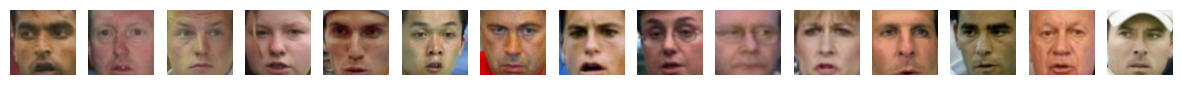

In [838]:
show_images(data[sad_list])

### After DLS: 

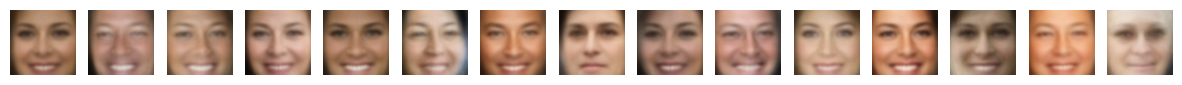

In [839]:
show_images(np.moveaxis(motivated_batch.numpy(), 1, -1))

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [10]:
BATCH_SIZE = 1024

In [11]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=TT.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=TT.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=40
)

val_loader = DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=40
)

/home/v_chernyy/myvenv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [12]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, orig_shape):
        super().__init__()
        
        flatten_dim = np.prod(list(orig_shape), dtype=int)
        
        self.orig_shape = orig_shape
        self.hidden_dim = hidden_dim
        
        self.encoder = Encoder(
            self.hidden_dim*2,
            flatten_dim
        )

        self.decoder = Decoder(
            self.hidden_dim,
            flatten_dim,
            orig_shape=orig_shape
        )
        
        self.training = True
        
    def get_sample(self, mu, logvar):
        
        var = (logvar / 2).exp()
        eps = torch.randn_like(var)
        
        return mu + var * eps
        
    def encode(self, x):
        x = self.encoder(x).view(-1, 2, self.hidden_dim)
        
        mu = x[:, 0]
        logsigma = x[:, 1]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = (logsigma / 2).exp()
            eps = torch.randn_like(sigma)
            
            return mu + sigma * eps
        
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        
        z = self.gaussian_sampler(mu, logsigma)
        
        reconstruction = self.decode(z)
        
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [60]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [186]:
class LitVAE(pl.LightningModule):
    def __init__(self, hidden_dim, orig_shape, n_epochs):
        super().__init__()
        
        self.n_epochs = n_epochs
        
        self.model = VAE(
            hidden_dim=hidden_dim,
            orig_shape=orig_shape,
        )
            
        self.val_loss_history = []
        
        self.criterion = loss_vae
        
        self.save_hyperparameters()
            
    def forward(self, x): 
        
        return self.model.forward(x)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=1e-3)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.n_epochs//3, eta_min=1e-8)
        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x, _ = train_batch
        
        mu, logsigma, reconstruction = self.forward(x)
        
        loss = self.criterion(x, mu, logsigma, reconstruction)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, _ = val_batch
        
        mu, logsigma, reconstruction = self.forward(x)
        
        loss = self.criterion(x, mu, logsigma, reconstruction)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'].detach().cpu() for x in outputs]).mean()
        
        self.val_loss_history.append(avg_val_loss.numpy())
        
        clear_output(wait=True)
        
        plt.plot(self.val_loss_history, label=f'Validation loss: {avg_val_loss.numpy():.3f}')
        plt.scatter(np.argmin(self.val_loss_history), y=min(self.val_loss_history), c='r', marker='*', label='min val loss')
        plt.scatter(len(self.val_loss_history)-1, y=avg_val_loss.numpy(), c='k', marker='o', label='current loss')
        
        plt.title(f'VAE, Epoch: {len(self.val_loss_history)-1}/{self.n_epochs}')
        
        plt.legend()
        plt.show()        

И обучим модель:

In [187]:
N_EPOCHS = 100

In [268]:
import gc

torch.cuda.empty_cache()
gc.collect()

115347

In [189]:
model = LitVAE(
    hidden_dim=100,
    orig_shape=train_loader.dataset[0][0].shape,
    n_epochs=N_EPOCHS
).to(DEVICE)

model.training = True

In [190]:
VAE_path='VAE_path'
!rm -rf checkpoints/VAE_path

In [191]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_loss',
    filename=VAE_path,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
    log_every_n_steps=len(train_loader)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


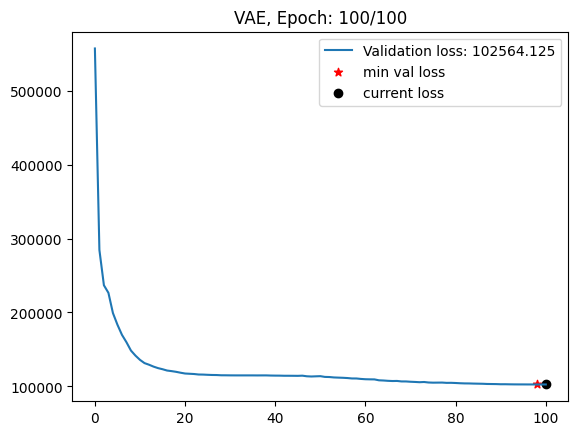

`Trainer.fit` stopped: `max_epochs=100` reached.


In [192]:
trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [30]:
batch = next(iter(val_loader))[0][:8]

In [210]:
with torch.no_grad():
    _, _, reconstructed_batch = model.model(batch)
    
reconstructed_batch.shape

torch.Size([8, 1, 28, 28])

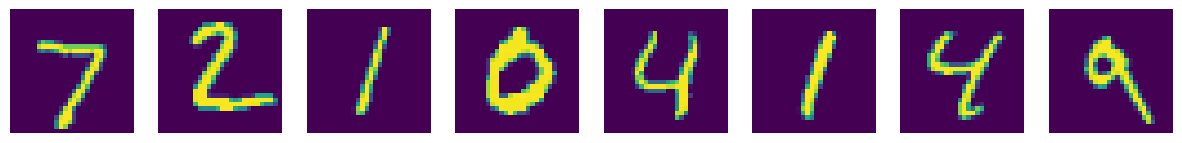

In [211]:
show_images(batch.squeeze())

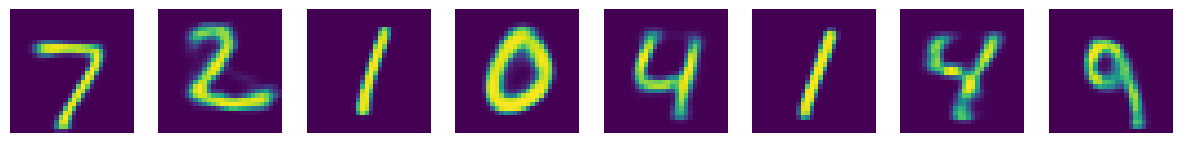

In [212]:
show_images(reconstructed_batch.squeeze())

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [220]:
model.training=False

In [221]:
z = torch.randn(10, 100)
output = model.model.decoder(z)

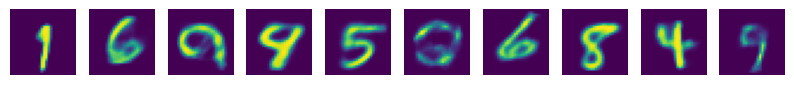

In [227]:
with torch.no_grad():

    # вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
    _, axes = plt.subplots(ncols=10, figsize=(10, 5))

    for img, ax in zip(output, axes.ravel()):

        ax.axis('off')
        ax.imshow(img.squeeze())

    plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощью `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [228]:
from sklearn.manifold import TSNE

In [230]:
latent_list = []
label_list = []

with torch.no_grad():
    
    for x, lab in val_loader:
        
        latent = model.model.encoder(x)
    
        latent_list.append(latent)
        label_list.append(lab)

In [240]:
latents = torch.concat(latent_list, 0)
labels = np.concatenate(label_list)

latents.shape, labels.shape

(torch.Size([10000, 200]), (10000,))

In [242]:
latent_embedded = TSNE(n_components=2).fit_transform(latents)

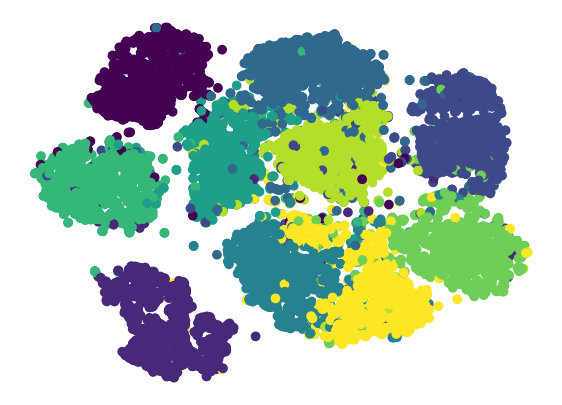

In [252]:
plt.figure(figsize = (7, 5))

plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], c=labels)
plt.axis('off')

plt.show()

Что вы думаете о виде латентного представления?

***Получились хорошо различимые кластеры.***

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [284]:
class CVAE(nn.Module):
    def __init__(self, hidden_dim, orig_shape):
        super().__init__()
        
        flatten_dim = np.prod(list(orig_shape), dtype=int)
        
        self.orig_shape = orig_shape
        self.hidden_dim = hidden_dim
        
        self.encoder = Encoder(
            self.hidden_dim*2,
            flatten_dim
        )

        self.decoder = Decoder(
            self.hidden_dim + 10,
            flatten_dim,
            orig_shape=orig_shape
        )
        
        self.training = True
        
    def get_sample(self, mu, logvar):
        
        var = (logvar / 2).exp()
        eps = torch.randn_like(var)
        
        return mu + var * eps
        
    def encode(self, x):
        x = self.encoder(x).view(-1, 2, self.hidden_dim)
        
        mu = x[:, 0]
        logsigma = x[:, 1]
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sigma = (logsigma / 2).exp()
            eps = torch.randn_like(sigma)
            
            return mu + sigma * eps
        
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        
        ohe = nn.functional.one_hot(class_num, num_classes=10)
        
        z = torch.cat([z, ohe], 1)
        
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        
        mu, logsigma = self.encode(x)
        
        z = self.gaussian_sampler(mu, logsigma)
        
        reconstruction = self.decode(z, class_num)
        
        return mu, logsigma, reconstruction

In [292]:
class LitCVAE(pl.LightningModule):
    def __init__(self, hidden_dim, orig_shape, n_epochs):
        super().__init__()
        
        self.n_epochs = n_epochs
        
        self.model = CVAE(
            hidden_dim=hidden_dim,
            orig_shape=orig_shape,
        )
            
        self.val_loss_history = []
        
        self.criterion = loss_vae
        
        self.save_hyperparameters()
            
    def forward(self, x, lab): 
        
        return self.model.forward(x, lab)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=1e-3)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.n_epochs//3, eta_min=1e-8)
        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x, lab = train_batch
        
        mu, logsigma, reconstruction = self.model.forward(x, lab)
        
        loss = self.criterion(x, mu, logsigma, reconstruction)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, lab = val_batch
        
        mu, logsigma, reconstruction = self.forward(x, lab)
        
        loss = self.criterion(x, mu, logsigma, reconstruction)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'].detach().cpu() for x in outputs]).mean()
        
        self.val_loss_history.append(avg_val_loss.numpy())
        
        clear_output(wait=True)
        
        plt.plot(self.val_loss_history, label=f'Validation loss: {avg_val_loss.numpy():.3f}')
        plt.scatter(np.argmin(self.val_loss_history), y=min(self.val_loss_history), c='r', marker='*', label='min val loss')
        plt.scatter(len(self.val_loss_history)-1, y=avg_val_loss.numpy(), c='k', marker='o', label='current loss')
        
        plt.title(f'CVAE, Epoch: {len(self.val_loss_history)-1}/{self.n_epochs}')
        
        plt.legend()
        plt.show()        

In [355]:
import gc

torch.cuda.empty_cache()
gc.collect()

57153

In [356]:
N_EPOCHS=100

In [357]:
model = LitCVAE(
    hidden_dim=100,
    orig_shape=train_loader.dataset[0][0].shape,
    n_epochs=N_EPOCHS
).to(DEVICE)

In [358]:
CVAE_path = 'CVAE_path'

In [359]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_loss',
    filename=CVAE_path,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
    log_every_n_steps=len(train_loader)
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


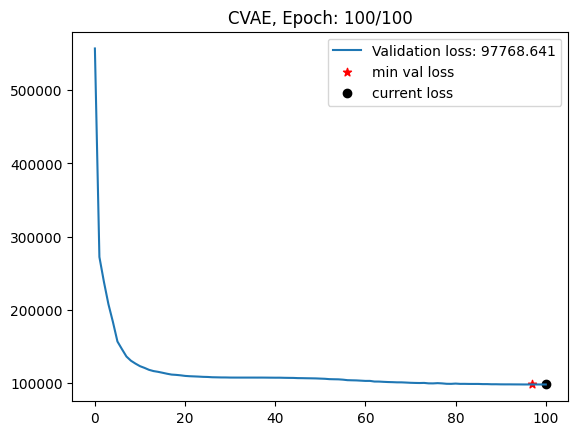

`Trainer.fit` stopped: `max_epochs=100` reached.


In [360]:
trainer.fit(
    model = model,
    train_dataloaders = train_loader,
    val_dataloaders = val_loader
)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [361]:
ls -l checkpoints

total 674692
-rw-rw-r-- 1 v_chernyy v_chernyy  33969426 дек 20 23:17 CVAE_path.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33969426 дек 20 23:19 CVAE_path-v1.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33969426 дек 20 23:22 CVAE_path-v2.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33969426 дек 20 23:48 CVAE_path-v3.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33954002 дек 20 21:17 VAE_path.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33954002 дек 20 21:23 VAE_path-v1.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33954002 дек 20 21:28 VAE_path-v2.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33954002 дек 20 21:40 VAE_path-v3.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33954002 дек 20 21:43 VAE_path-v4.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33953938 дек 20 21:56 VAE_path-v5.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy  33953938 дек 20 22:20 VAE_path-v6.ckpt
-rw-rw-r-- 1 v_chernyy v_chernyy 317276242 дек 20 04:32 vanilla_AE_pathAE.ckpt


In [366]:
model = LitCVAE.load_from_checkpoint(f'checkpoints/CVAE_path-v3.ckpt')

In [367]:
z = torch.FloatTensor(np.random.randn(1, 100))
z.shape

torch.Size([1, 100])

In [368]:
model.model.training = False

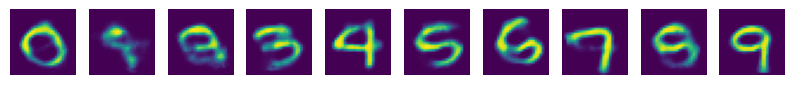

In [370]:
# сгенерируем 25 рандомных векторов размера latent_space

with torch.no_grad():
    _, axes = plt.subplots(ncols=10, figsize=(10, 5))

    for img_id, ax in zip(range(10), axes.ravel()):

        ax.axis('off')
        img_id = torch.tensor(img_id).unsqueeze(0)
        ax.imshow(model.model.decode(z, img_id).squeeze())

    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [371]:
latent_list = []
label_list = []

with torch.no_grad():
    
    for x, lab in val_loader:
        
        latent = model.model.encoder(x)
    
        latent_list.append(latent)
        label_list.append(lab)

In [372]:
latents = torch.concat(latent_list, 0)
labels = np.concatenate(label_list)

latents.shape, labels.shape

(torch.Size([10000, 200]), (10000,))

In [373]:
latent_embedded = TSNE(n_components=2).fit_transform(latents)

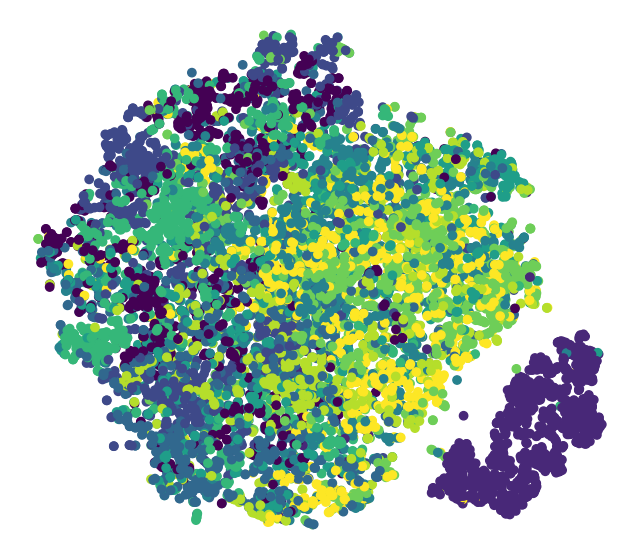

In [376]:
plt.figure(figsize = (8, 7))

plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], c=labels)
plt.axis('off')

plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

***CVAE, вероятно, требуется априорная информация для разделения классов***

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>